# K-Means Algorithm

In this notebook, a standard K-means clustering algorithm is used. K-means has the advantage that new data points can be added and their cluster predicted after training the model. This means the model can be trained quickly for less memory using a subset of the data. 

This notebook touches on the discussion of what the requirements should be to select an algorithm for unsupervised dominant balance identification. 

First, the same preprocessing is done, as in the ```Boundary_Layer``` Notebook.

In [34]:
import numpy as np
from numpy.random import randint
import h5py
import sys
import os
from sklearn.cluster import KMeans
from sklearn.decomposition import SparsePCA
from scipy.optimize import curve_fit, root
from scipy.integrate import odeint


# adding Tools to the system path
sys.path.insert(0, "../Tools/")
import plot_funcs as pf
import preprocessing as pp
import blasius_solution as bs

In [35]:
# creating the directory for the plots
cur_dir = os.getcwd()
proj_dir = os.path.dirname(cur_dir)
plots_dir = os.path.join(proj_dir, "Plots/BL")
os.makedirs(plots_dir, exist_ok=True)

# 1. Preprocessing

## a. Load the data

In [36]:
# Load the data from http://turbulence.pha.jhu.edu/Transition_bl.aspx
file = h5py.File("../Data/Transition_BL_Time_Averaged_Profiles.h5", "r")

In [37]:
# Get arrays for variables and the Reynold's averages
x = np.array(file["x_coor"])
y = np.array(file["y_coor"])
u_bar = np.array(file["um"])
v_bar = np.array(file["vm"])
p_bar = np.array(file["pm"])
R_uu = np.array(file["uum"]) - u_bar**2
R_uv = np.array(file["uvm"]) - u_bar * v_bar

In [38]:
# Visualize by wall-normal Reynolds stress
X, Y = np.meshgrid(x, y)

# Include line of 99% of free flow mean velocity
# Values from http://turbulence.pha.jhu.edu/docs/README-transition_bl.pdf
U_inf = 1
nu = 1 / 800
Re = (U_inf / nu) * x

## b. Get the finite difference derivatives to estimate the gradients

__NOTE: VARIABLE STEP SIZE IN Y DIRECTION ONLY__

In [39]:
# Get space steps

dx = x[1] - x[0]
dy = y[1:] - y[:-1]

nx = len(x)  # Number of points in x
ny = len(y)  # Number of points in y

# Get the derivatives
u_x, u_y, lap_u, v_y, p_x, R_uux, R_uvy = pp.get_derivatives_numpy(
    nx, ny, dx, y, u_bar, y, p_bar, R_uu, R_uv
)

# Flatten arrays for matrix multiplication, using fortran ordering
u_bar = u_bar.flatten("F")
v_bar = v_bar.flatten("F")
p_bar = p_bar.flatten("F")
R_uu = R_uu.flatten("F")
R_uv = R_uv.flatten("F")

# Flatten the derivative terms arrays for the rest of the notebook
lap_u = lap_u.flatten("F")
R_uux = R_uux.flatten("F")
R_uvy = R_uvy.flatten("F")
u_x = u_x.flatten("F")
u_y = u_y.flatten("F")
v_y = v_y.flatten("F")
p_x = p_x.flatten("F")

## c. Equation space representation

In [40]:
# Labels of terms in the RANS equation
labels = [
    r"$\bar{u} \bar{u}_x$",
    r"$\bar{v}\bar{u}_y$",
    r"$\rho^{-1} \bar{p}_x$",
    r"$\nu \nabla^2 \bar{u}$",
    r"$\overline{(u^\prime v^\prime)}_y$",
    r"$\overline{({u^\prime} ^2)}_x$",
]

In [41]:
# Get terms stored as features
features = 1e3 * np.vstack([u_bar * u_x, v_bar * u_y, p_x, nu * lap_u, R_uvy, R_uux]).T
nfeatures = features.shape[1]

# 2. K-Means


Again, a standard K-Means algorithm is used here. Because there is much higher density close to the origin, by using a high number of clusters, that high density region will be separated into multiple clusters, and not just clustered into one group.

## a. Train the model and predict for full dataset

In [42]:
# Train K-means model

# Fit K-Means model
nc = 14  # Number of clusters
seed = 75016
np.random.seed(seed)
model = KMeans(n_clusters=nc, n_init=10, random_state=seed)

# Train on only a subset (10%) of the data
sample_pct = 0.1
mask = np.random.permutation(features.shape[0])[: int(sample_pct * features.shape[0])]

# Fit the model
model.fit(features[mask, :])

KMeans(n_clusters=14, n_init=10, random_state=75016)

In [43]:
# Predict clusters for all data
clustering = model.predict(features)

# Get covariances in each cluster
covs = np.zeros((nc, nfeatures, nfeatures))
for i in range(nc):
    mask_ = clustering == i
    covs[i, :, :] = np.cov(features[mask_, :].T)

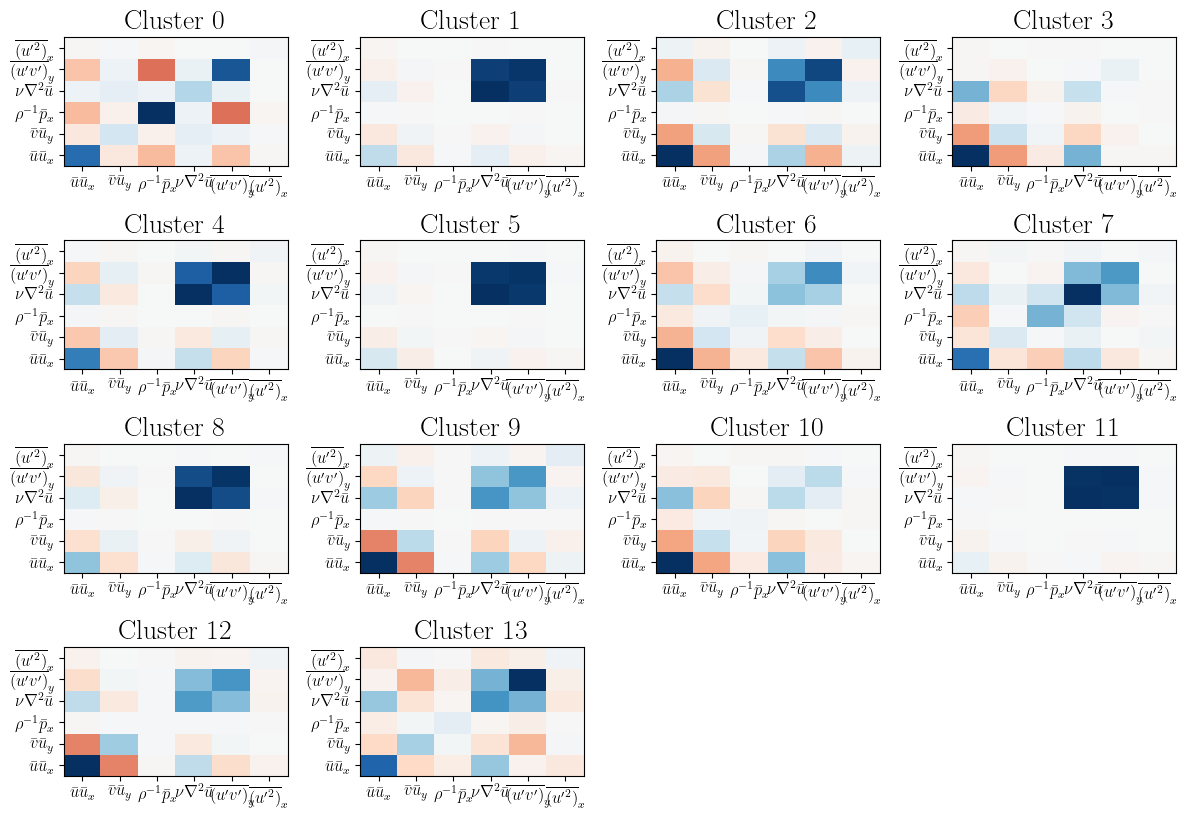

In [44]:
# Plot covariance matrices for each K-Means cluster
pf.plot_cov_mat(covs, nfeatures, nc, labels, "Other", f"BL/KMeans_CovMat_{nc}")

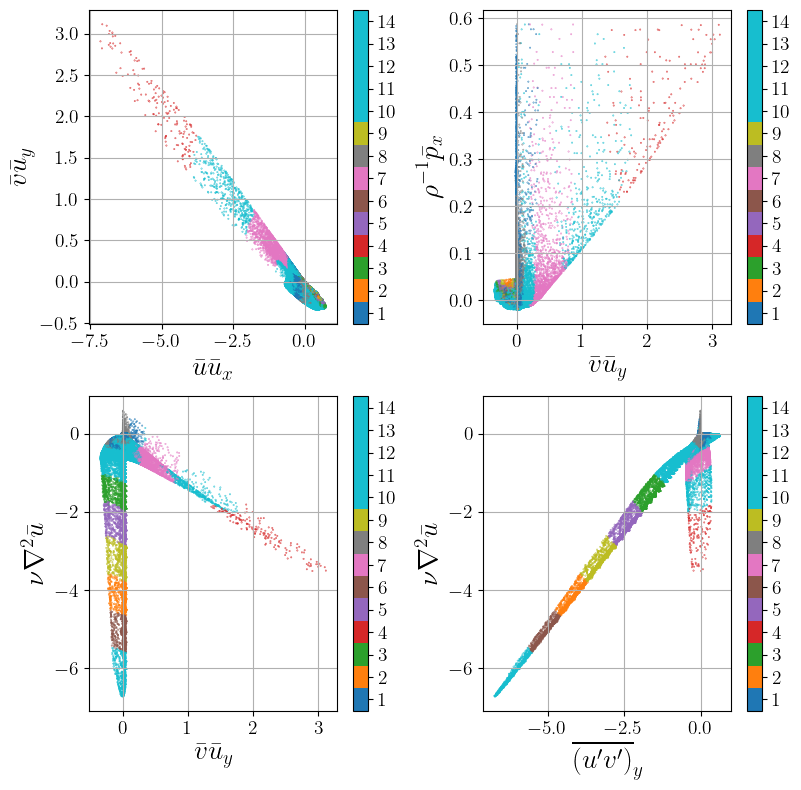

In [45]:
# Visualize GMM clustering with 2D views of equation space

cluster_idx = clustering + 1

pf.plot_clustering_2d_eq_space(
    features[mask, :], cluster_idx[mask], nc, f"BL/KMeans_2D_eq_space_{nc}"
)

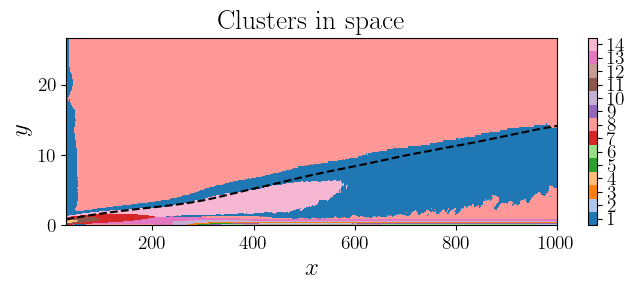

In [46]:
# Assign points in space to each cluster
cluster_idx = clustering
clustermap = np.reshape(cluster_idx, [ny, nx], order="F")

# Visualize the clustering in space
pf.plot_clustering_space(
    clustermap, x, y, X, Y, nx, ny, nc, u_bar, U_inf, f"BL/KMeans_Clustering_Space_{nc}"
)

With high cluster number, it seems like clusters close to those identified in the GMM case are found, with the general boundary layer being visible. However, there are substantial differences which may be due to K-Means usually resulting in similar sized clusters, which in this case of regions in space of different sizes needing to be clustered will be difficult.

## b. Sparce Principal Component Analysis (SPCA) dimensionality reduction

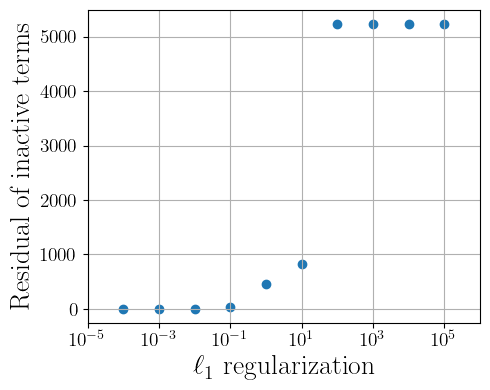

In [47]:
# Computing the residuals of Sparse PCA to find the optimal alpha value

alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5]
err = np.zeros([len(alphas)])


def spca_err(alpha, cluster_idx, features, nc):
    err_ = 0

    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.where(cluster_idx == i)[0]
        cluster_features = features[feature_idx, :]

        # Conduct Sparse PCA
        spca = SparsePCA(n_components=1, alpha=alpha, random_state=seed)
        spca.fit(cluster_features)

        # Get the inactive terms
        inactive_terms = np.where(spca.components_[0] == 0)[0]

        err_ += np.sqrt(np.sum((cluster_features[:, inactive_terms].ravel()) ** 2))

    return err_


from joblib import Parallel, delayed

err = Parallel(n_jobs=4)(
    delayed(spca_err)(alpha, cluster_idx, features, nc) for alpha in alphas
)


pf.plot_spca_residuals(alphas, err, f"BL/KMeans_spca_residuals_{nc}")

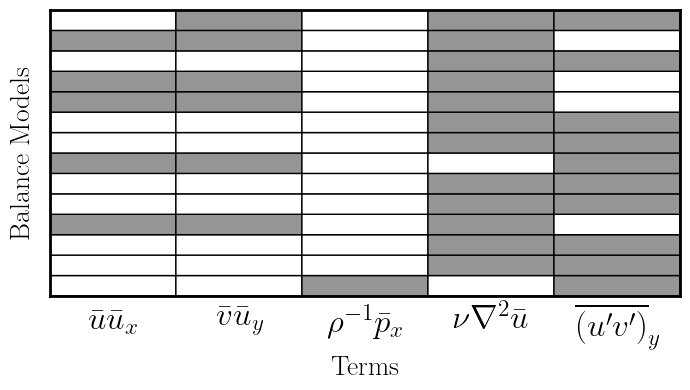

In [48]:
# Get the active terms for each cluster for optimal alpha

alpha_opt = 8  # Optimal alpha value

spca_model = np.zeros([nc, nfeatures])  # Store the active terms for each cluster

for i in range(nc):
    feature_idx = np.nonzero(cluster_idx == i)[0]
    cluster_features = features[feature_idx, :]

    spca = SparsePCA(
        n_components=1, alpha=alpha_opt, random_state=seed
    )  # normalize_components=True
    spca.fit(cluster_features)

    active_terms = np.nonzero(spca.components_[0])[0]
    if len(active_terms) > 0:
        spca_model[i, active_terms] = 1  # Set the active terms to 1

# Plot the active terms for each cluster
pf.plot_balance_models(
    spca_model, labels, False, f"BL/KMeans_active_terms_{nc}_{alpha_opt}"
)

## c. Resulting Final Dominant Balance Models

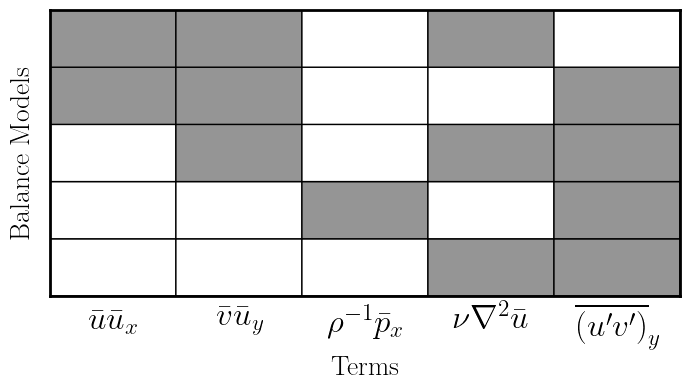

In [49]:
# Identify clusters with identical balance models
balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)
nmodels = balance_models.shape[0]

# Make new cluster_idx based on the unique SPCA balance model
balance_idx = np.array([model_index[i] for i in cluster_idx])
balancemap = np.reshape(balance_idx, [ny, nx], order="F")

# Plot the active terms for each unique balance model
pf.plot_balance_models(
    balance_models, labels, False, f"BL/KMeans_unique_active_terms_{nc}_{alpha_opt}"
)

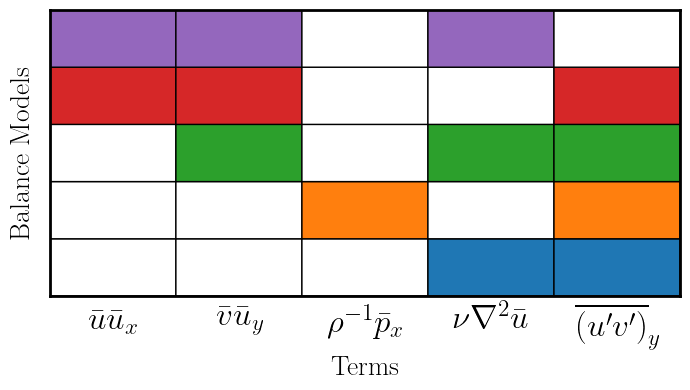

In [50]:
# Plot the unique balance models
pf.plot_balance_models(
    balance_models, labels, True, f"BL/KMeans_balance_models_{nc}_{alpha_opt}"
)

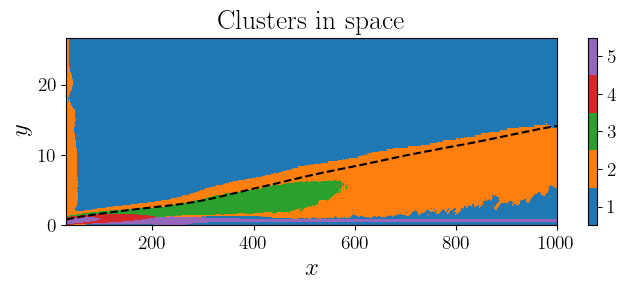

In [51]:
# Plot the clustering in space with unique balance models
pf.plot_clustering_space(
    balancemap,
    x,
    y,
    X,
    Y,
    nx,
    ny,
    nmodels,
    u_bar,
    U_inf,
    f"BL/KMeans_spca_clustering_{nc}_{alpha_opt}",
)

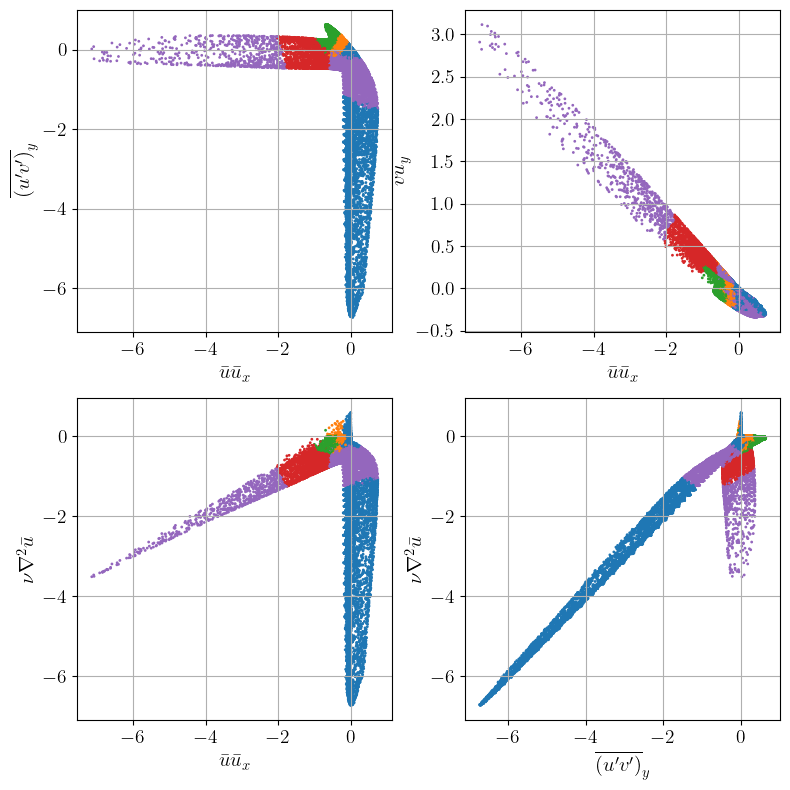

In [52]:
# 2D views of feature space
pf.plot_feature_space(
    features[mask, :], balance_idx[mask], f"BL/KMeans_feature_space_{nc}_{alpha_opt}"
)

With multiple clusters being made up of the points in the "branches" in equation space, these end up being described by the same dominant balance after applying SPCA, and therefore are grouped as one cluster. This is also one of the advantages of the Callaham et al. (2021) paper which allows for a conservative choice of cluster number as SPCA will then identify the cluster that have the same active terms.

Here, mulitple are obtained, the first is the viscous sublayer in red or blue, though the blue cluster occupies the rest of what would be the free flow. The 2nd is the inflow region with low Reynold's stress (purple). The third is the green region which is the transitional regions, and the orange region which is the inertial sublayer.


## Outer Layer Scaling

The length scale of the outer layer should scale with $ \ell \sim x^{4/5} $ (see pg 71 in Holmes, Lumley, Berkooz or pg 638 in Schlichting)

As a rough diagnostic of our balance model, define the outer layer length scale as the wall-normal coordinate where the balance changes from the inertial sublayer to the free-stream (once the transitional region has disappeared).

[0.05995832 0.79538655]


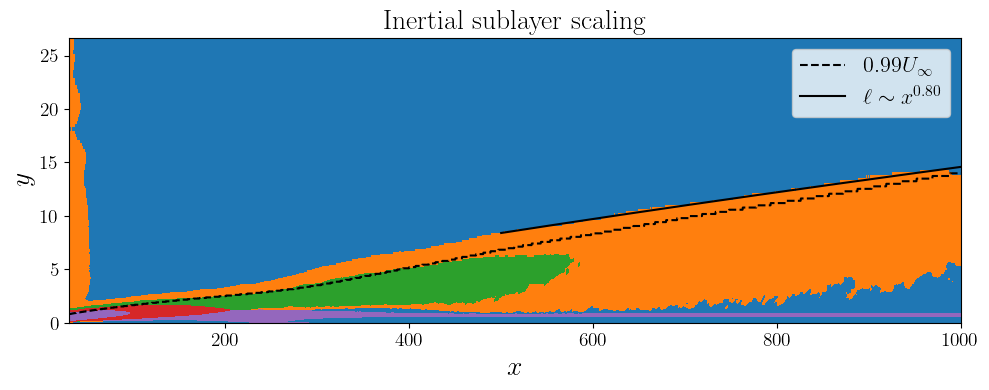

In [53]:
# Create a u_bar field:
u_map = np.reshape(u_bar, (ny, nx), order="F")

# Find which cluster is the inertial sublayer.
if nc == 14 and alpha_opt == 8:
    inert_sub_idx = [0]
else:
    print(
        "You must identify the inertial sublayer cluster manually from the balance models."
    )

# Define some variables
x_min = 110  # Where inertial balance begins
x_turb = 500  # Where transitional region ends

x_idx = np.nonzero(x > x_min)[0]
x_layer = x[x_idx]

# First, find the upper extent of the inertial sublayer
y_gmm = np.zeros(len(x_idx))
# Loop through wall-normal direction until the balance changes
for i in range(len(x_idx)):
    j = len(y) - 1
    while balancemap[j, x_idx[i]] == inert_sub_idx:
        j -= 1
    y_gmm[i] = y[j]  # Store upper value of inertial balance

# Next, find the 99% of free stream velocity line
delta = np.zeros(len(x))
# Loop until velocity falls past 99% freestream
for i in range(len(x)):
    j = 0
    while u_map[j, i] < 0.99:
        j += 1
    delta[i] = y[j - 1]

# Fit inertial balance to power law
power_law = lambda x, a, b: a * x**b

x_to_fit = x_layer > x_turb  # End of transitional region
p_gmm, cov = curve_fit(power_law, x_layer[x_to_fit], y_gmm[x_to_fit])
gmm_fit = power_law(x_layer, *p_gmm)
print(p_gmm)


# Plot the inertial sublayer scaling
pf.plot_sublayer_scaling(
    x,
    y,
    balancemap,
    delta,
    x_layer,
    gmm_fit,
    p_gmm,
    x_to_fit,
    f"BL/KMeans_sublayer_scaling_{nc}_{alpha_opt}",
)

Since the model did not identify an inertial sublayer, but just a large cluster that combines the free stream, inertial sublayer, and transitional region, here the $l \sim x^{4/5}$ scaling is not obtained

## Self-similarity

In the near-wall region (viscous sublayer), we should be able to collapse the profiles using wall units $u^+$, $y^+$. These wall units are defined as: 
- $y^{+}=\frac{y u_{\tau}}{\nu}$, the distance $y$ to the wall, dimensionaless using friction velocity $u_{\tau}$, and kinematic viscosity $\nu$.
- $u^{+}=\frac{u}{u_{\tau}}$, the dimensonless velocity as a function of y.

Here we show that this universality breaks down at approximately the same place where the identified viscous sublayer balance ends. Therefore demonstrating the identified balance models follow fluid dynamics theory.

As shown in the figure above, the wall-normal extent of the sublayer (blue/red) is approximately constant in the fully-developed turbulent region. We observe below that this is given by $y^+ \sim 33$.

[Wikipedia](https://en.wikipedia.org/wiki/Law_of_the_wall)

34.7983652647016
34.83952782339704
34.079410639225394
33.423992340359376
33.846066356283124


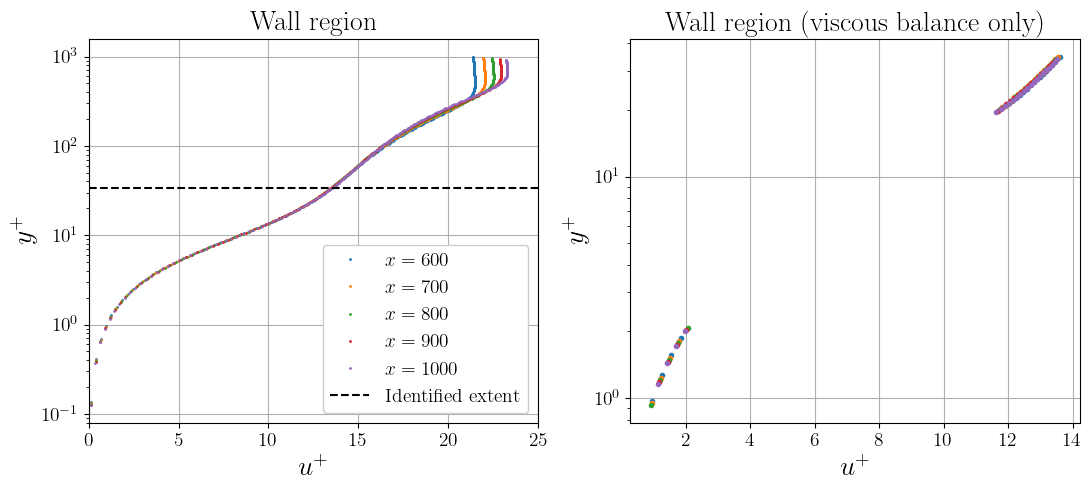

In [54]:
# Compute friction velocity with an estimate of the wall shear stress
u_tau = np.sqrt(nu * u_y[::ny])

# Define wall units
y_plus = np.outer(y, u_tau / nu)
u_plus = np.reshape(u_bar, [ny, nx], order="F") / u_tau

# Plot the self-similarity of the flow
# This is run for the specific case of 14 clusters and alpha_opt = 8
# You may need to adjust the cluster index for the viscous sublayer
pf.plot_self_similarity(
    x, 4, y_plus, u_plus, balancemap, f"BL/KMeans_self_similarity_{nc}_{alpha_opt}"
)

Here, we see that the identified extent of the viscous sublayer is much lower than where the flow profiles diverge, where the true viscous sublayer actually ends. Thus, the K-Means algorithm did identify a viscous sublayer region but it is too shallow.

## Blasius solution in laminar regime

We also find that there is an inflow region without significant Reynolds stress (purple), which suggests this flow is approximately laminar, until the clustered large (orange/green) region is important around $x\sim 90$.  Before that we would expect the Blasius boundary layer solution to hold.

__Blasius solution:__
$$ \eta = y \sqrt{\frac{U}{2\nu x} }$$
$$ u = U f'(\eta) $$
[Wikipedia](https://en.wikipedia.org/wiki/Blasius_boundary_layer#Blasius_equation_-_first-order_boundary_layer)

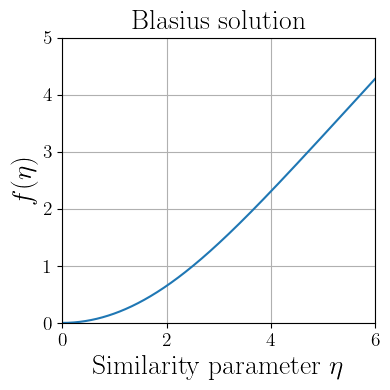

In [55]:
# Solve Blasius equations numerically

# Arbitrary "infinite" upper limit for domain
eta_inf = 200
# Step size
d_eta = 0.01
eta = np.arange(0, eta_inf, d_eta)

# Initial guess for unknown initial condition
F_init = [0, 0, 0]

# Solve root-finding problem for unknown initial condition
opt_res = root(bs.bc_fn, F_init, tol=1e-4)
F0 = [0, 0, opt_res.x[2]]

# Evaluate with resulting initial conditions
f = odeint(lambda y, t: bs.blasius_rhs(y), F0, eta)

pf.plot_blasius_solution(eta, f, f"BL/KMeans_blasius_solution_{nc}_{alpha_opt}")

Then we can compare the inflow profile to the Blasius solution.

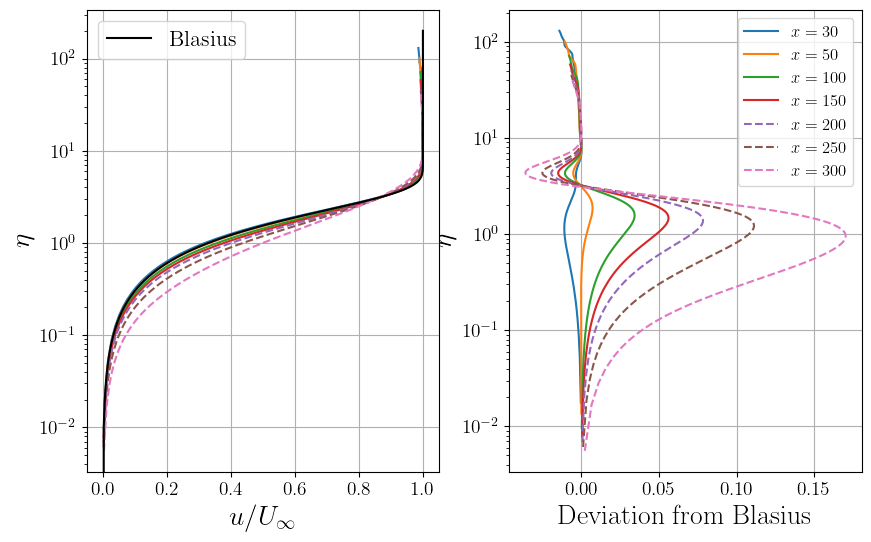

In [56]:
pf.plot_blasius_deviation(
    x,
    y,
    nx,
    ny,
    u_bar,
    eta,
    f,
    U_inf,
    nu,
    f"BL/KMeans_blasius_deviation_{nc}_{alpha_opt}",
)

It can be seen that until $x \sim 150$ there is a maximum deviation of about 6% from the Blasius solution. This indicates that the algorithm should have likely identified a larger area for the green laminar inflow region.